In [185]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, spectrogram, convolve, find_peaks, savgol_filter
from scipy.io import wavfile
import sounddevice as sd
import subprocess

from utilities import *
from frft import *

In [236]:
# constellation_map = {
#     '00' : complex(1/np.sqrt(2), 1/np.sqrt(2)),
#     '01' : complex(-1/np.sqrt(2), 1/np.sqrt(2)),
#     '11' : complex(-1/np.sqrt(2), -1/np.sqrt(2)),
#     '10' : complex(1/np.sqrt(2), -1/np.sqrt(2)),
# }
constellation_map = {
    0: 1,
    1: -1,
}

QAM_symbols = np.array([*constellation_map.values()])
QAM_bits = np.array([*constellation_map.keys()])

In [237]:
N = 8192
L = 1024

np.random.seed(0)
source = np.random.choice(list(constellation_map.values()), (N-2)//2)
subcarrier_data = np.concatenate(([0], source, [0], np.conjugate(np.flip(source))))
x = np.fft.ifft(subcarrier_data).real
OFDM_symbol = np.concatenate((x[-L:], x))
OFDM_symbol /= np.max(np.abs(OFDM_symbol))

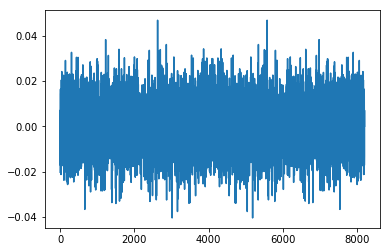

In [238]:
plt.plot(x)

In [239]:
fs = 48000

t = np.linspace(0,1,fs)
chirp_standard = chirp(t, 1e3, 1, 10e3, method='linear')

pause = np.zeros(fs)

np.random.seed(1)
whitenoise = np.random.randn(fs)
whitenoise /= np.max(np.abs(whitenoise))

standard = np.concatenate([pause, chirp_standard, pause, whitenoise, pause])

OFDM_frame = np.tile(OFDM_symbol, 10)
signal = np.concatenate([standard, OFDM_frame])

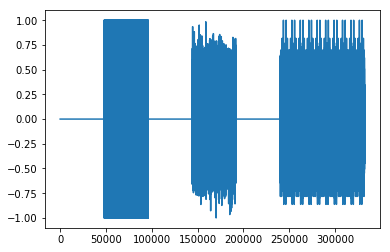

In [240]:
plt.plot(signal)

In [93]:
sd.play(signal, samplerate=fs, blocking=True)
write('OFDM/test_frame.wav', fs, signal)

In [241]:
#subprocess.Popen(["afplay", "OFDM/test_frame.wav"])
#received = sd.rec(len(signal), samplerate = fs, channels = 1, blocking = True).flatten()
#write('OFDM/received_frame.wav', fs, received)
received = np.array(read('OFDM/received_frame.wav', fs)[1])

# MUST CHANGE LATER! DEBUGGING ONLY
#received = signal

In [242]:
def window(x):
    return x * np.hanning(len(x))

def synchronise(received, chirp_standard):
    conv = convolve(window(received), np.flip(window(chirp_standard)), mode='same')
    return np.argmax(np.abs(conv))

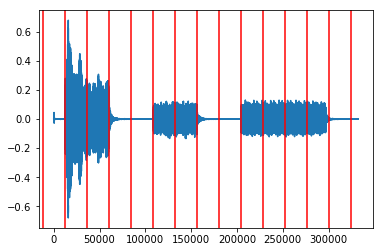

In [243]:
%matplotlib inline
plt.plot(received)
start = synchronise(received, chirp_standard)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.show()

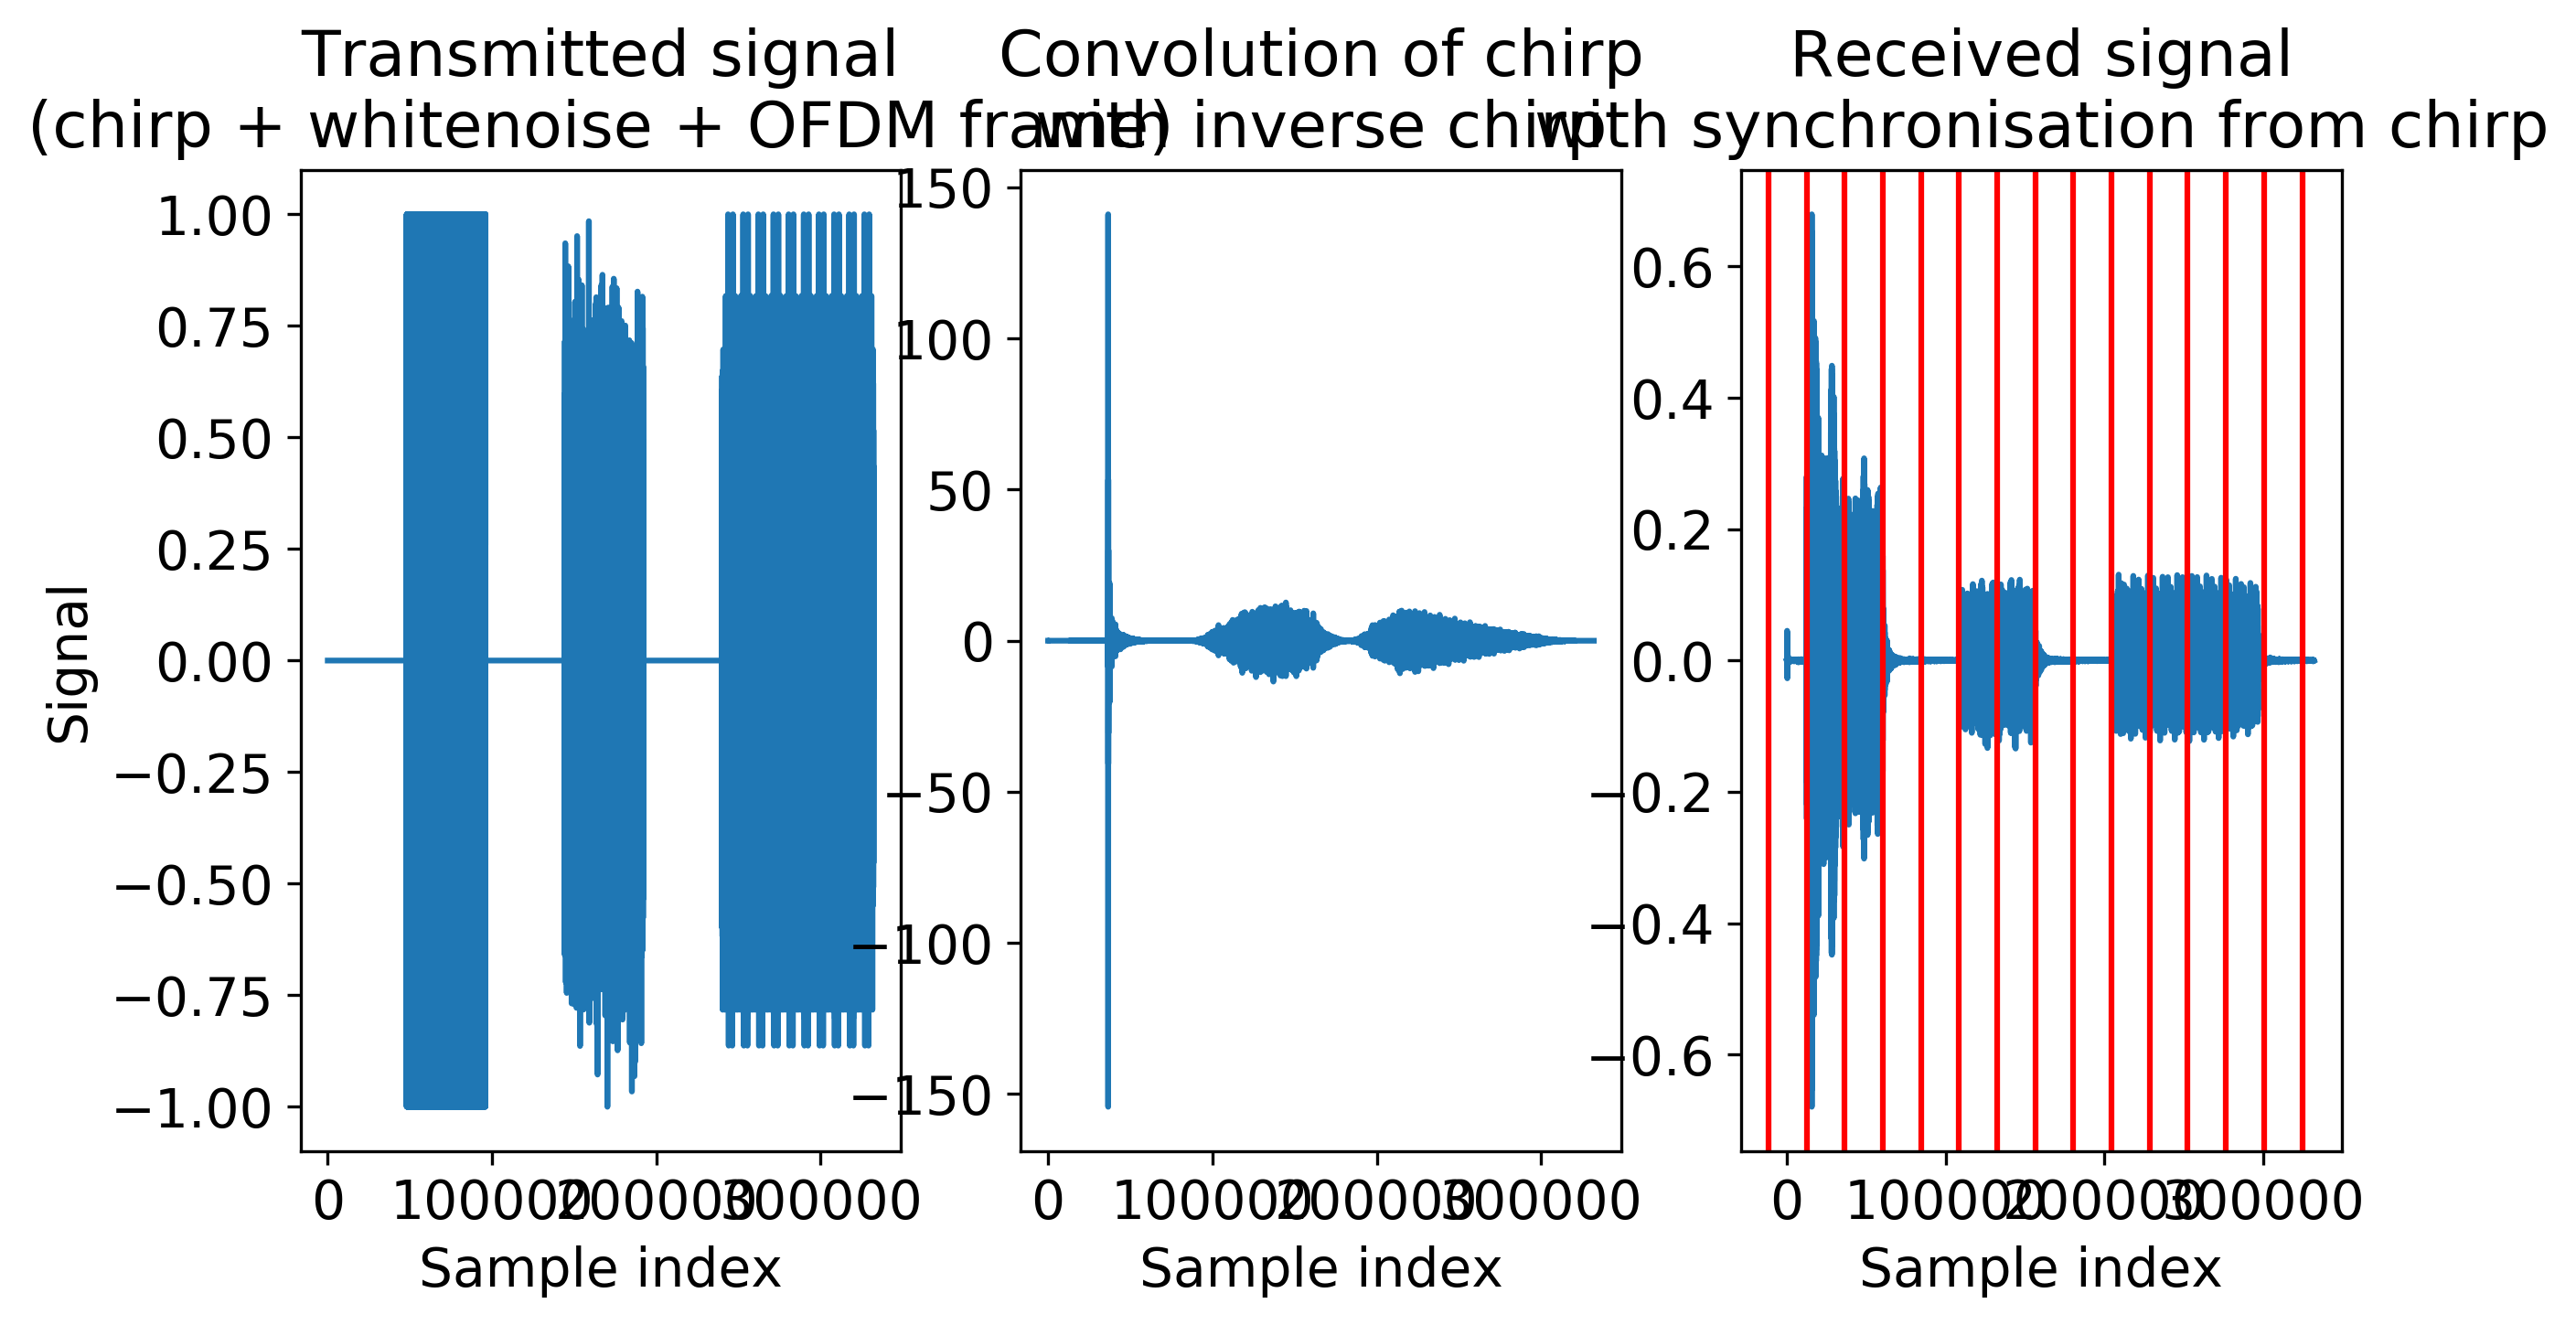

In [244]:
%matplotlib qt
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
plt.plot(signal)
plt.xlabel('Sample index')
plt.ylabel('Signal')
plt.title('Transmitted signal\n(chirp + whitenoise + OFDM frame)')
plt.locator_params(axis='x', nbins=4)

plt.subplot(1,3,2)
plt.plot(convolve(window(received), np.flip(window(chirp_standard)), mode='same'))
plt.xlabel('Sample index')
plt.title('Convolution of chirp\nwith inverse chirp')
plt.locator_params(axis='x', nbins=4)

plt.subplot(1,3,3)
plt.plot(received)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.xlabel('Sample index')
plt.title('Received signal\nwith synchronisation from chirp')
plt.locator_params(axis='x', nbins=4)

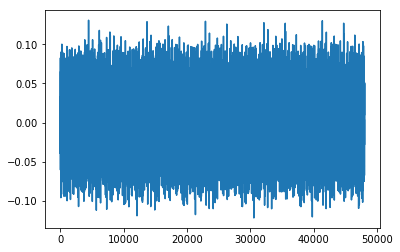

In [245]:
%matplotlib inline
received_frame = received[start+int(3.5*fs):start+int(4.5*fs)]
plt.plot(received_frame)

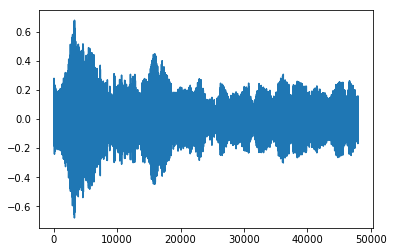

In [246]:
received_chirp = received[start-int(0.5*fs):start+int(0.5*fs)]
plt.plot(received_chirp)

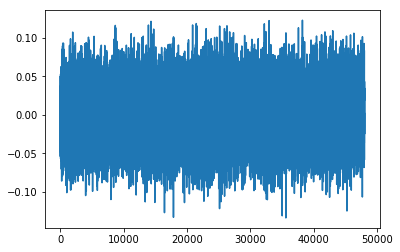

In [247]:
received_whitenoise = received[start+int(1.5*fs):start+int(2.5*fs)]
plt.plot(received_whitenoise)

## FrFT Channel estimation

In [201]:
res = optimise_a(chirp_standard)
res

     fun: -83.4300435978929
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 1.118010721541389

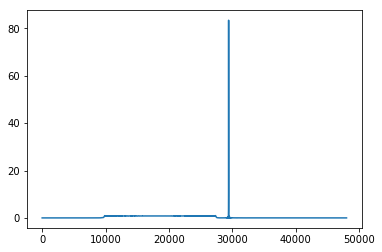

In [202]:
plt.plot(np.abs(frft(chirp_standard, res.x)))

## White noise channel estimation

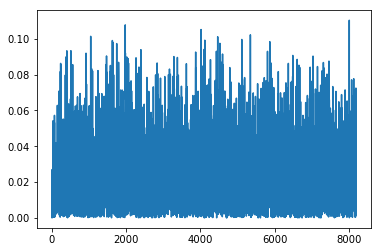

In [70]:
plt.plot(np.abs(received_whitenoise)[:N])
# plt.xscale('log')
# plt.yscale('log')

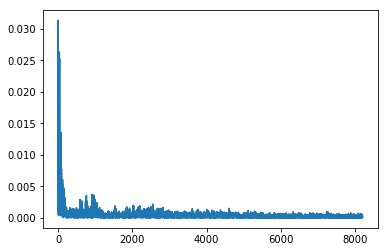

In [71]:
plt.plot(np.abs(np.fft.ifft(np.fft.fft(received_whitenoise)/np.fft.fft(whitenoise)))[:N])

## Known OFDM decoding

In [248]:
X = subcarrier_data

n = 5
R = np.zeros((5,N), dtype=complex)

for i in range(1,n+1):
    r = received_frame[i*(L+N)-N:i*(L+N)]
    R[i-1,:] = np.fft.fft(r)

# For test 
H = np.mean(R, axis=0)/X
H

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


array([       -inf       +nanj, -0.11194314+0.00299302j,
        0.11478221-0.00278423j, ...,  0.11676552+0.00525573j,
        0.11478221+0.00278423j, -0.11194314-0.00299302j])

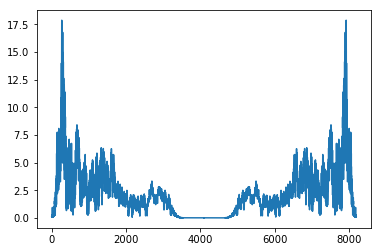

In [249]:
plt.plot(np.abs(H))

(0, 50)

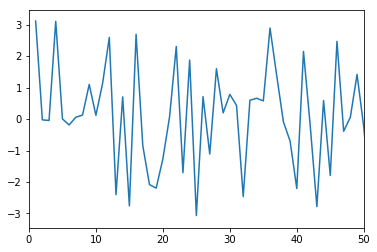

In [250]:
plt.plot(np.angle(H))
plt.xlim(0,50)

## Decoding

In [251]:
received_frame

array([-0.01267572, -0.00106297,  0.00501072, ...,  0.02946023,
        0.0461041 ,  0.01020162], dtype=float32)

In [252]:
r = received_frame[L:(L+N)]

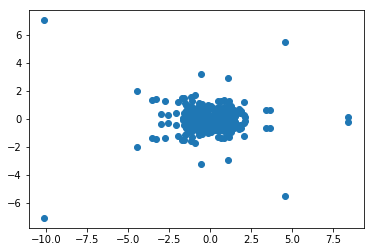

In [254]:
%matplotlib inline
R = np.fft.fft(r)
Xhat = R/H # deconvolution

plt.scatter(Xhat.real, Xhat.imag)

## Convolution channel estimation

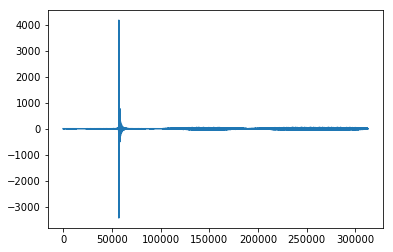

In [148]:
%matplotlib inline
conv = convolve(received, np.flip(chirp_standard), mode='same')
plt.plot(conv)

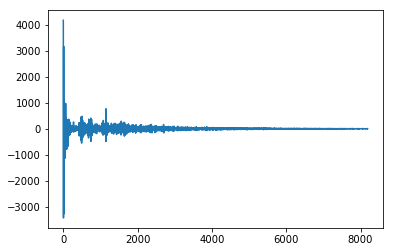

In [111]:
%matplotlib inline
impulse = conv[start:start+N]
plt.plot(conv[start:start+N])

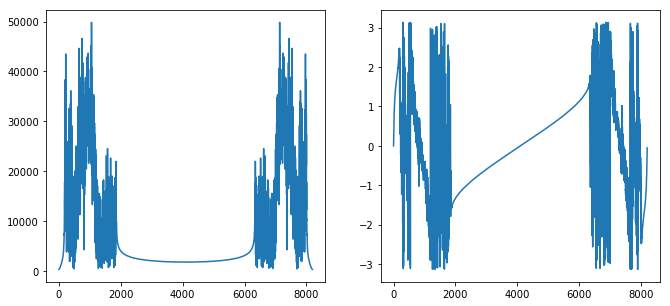

In [112]:
H = np.fft.fft(impulse)
plt.subplots(figsize=(11,5))
plt.subplot(1,2,1)
plt.plot(np.abs(H))
plt.subplot(1,2,2)
plt.plot(np.angle(H))

In [96]:
from scipy.signal import find_peaks

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


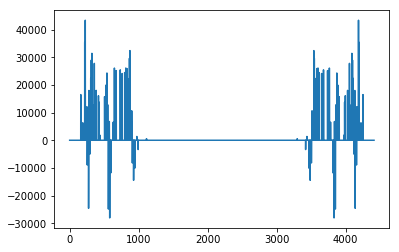

In [97]:
peaks, _ = find_peaks(np.abs(H), prominence=0.5, width=3)
H_smooth = np.zeros(len(H))
H_smooth[peaks] = H[peaks]
plt.plot(H_smooth)

Text(0.5, 1.0, 'Impulse response (chirp cross-correlation)')

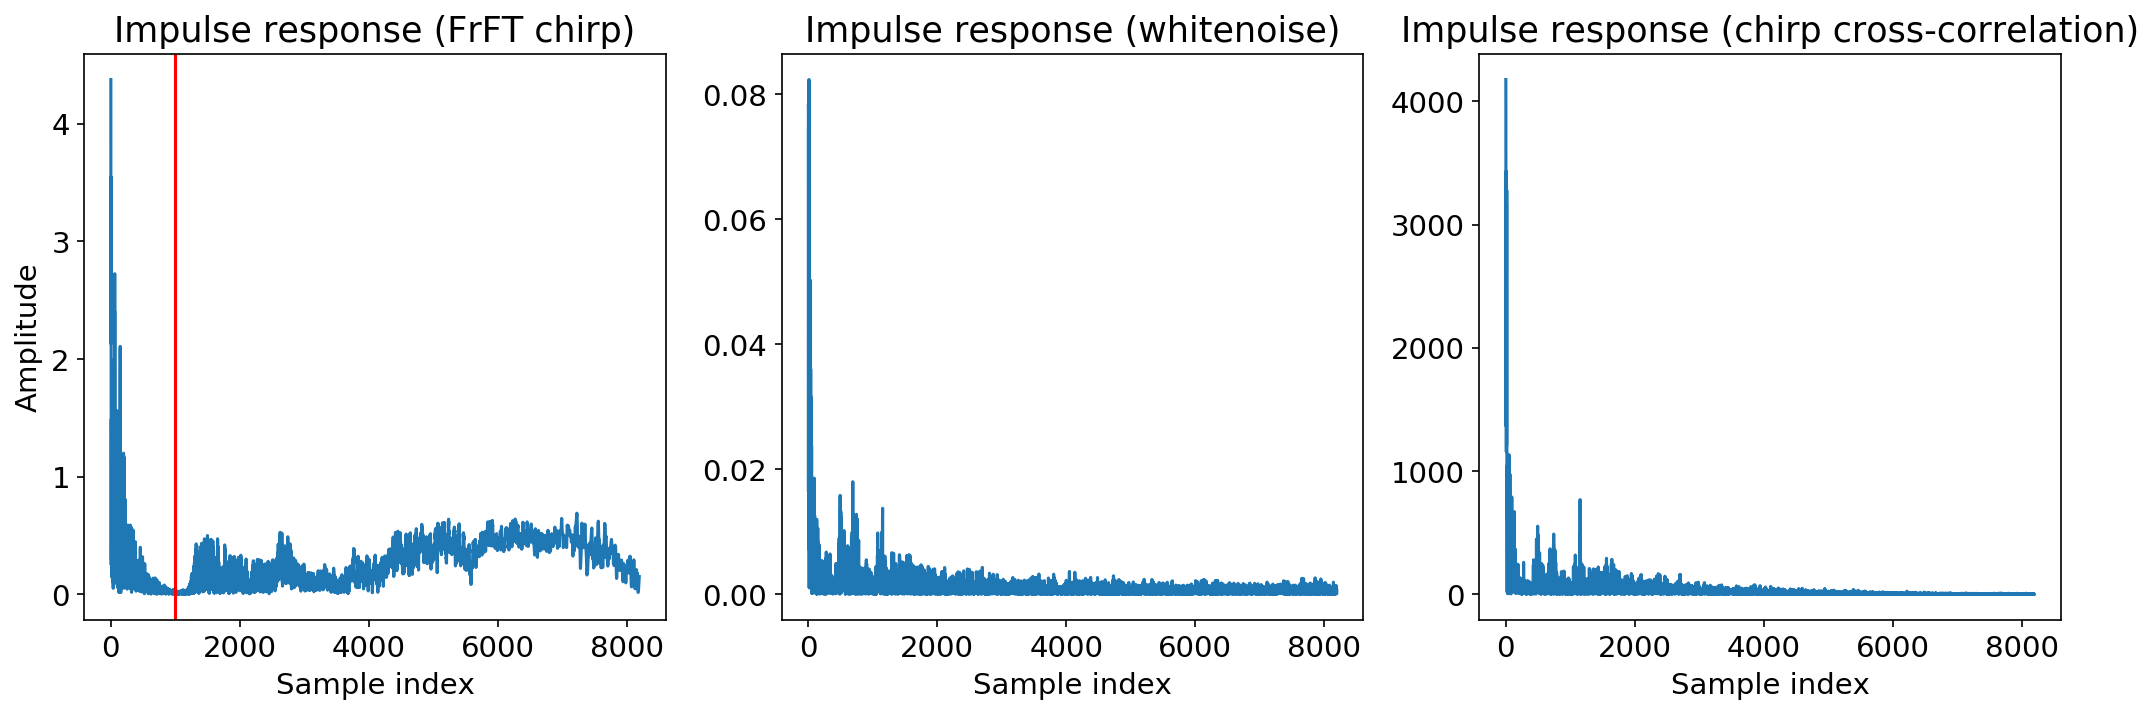

In [173]:
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
peak= np.argmax(Y_alpha_opt_t)
h = Y_alpha_opt_t[peak:peak+N]
plt.plot(np.abs(h))
plt.axvline(1000, c='r')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('Impulse response (FrFT chirp)')

plt.subplot(1,3,2)
plt.plot(np.abs(np.fft.ifft(np.fft.fft(received_whitenoise)/np.fft.fft(whitenoise)))[:N])
plt.xlabel('Sample index')
plt.title('Impulse response (whitenoise)')

plt.subplot(1,3,3)
plt.plot(np.abs(conv[start:start+N]))
plt.xlabel('Sample index')
plt.title('Impulse response (chirp cross-correlation)')